### Task 1: Baseline GCN 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import os, random, numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')

In [3]:
# This is done to ensure determinism with GraphGPS model
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.set_num_threads(1)

In [4]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}\n")

Dataset: Cora
Number of nodes: 2708
Number of features: 1433
Number of classes: 7



In [5]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        assert num_layers >= 2, "Need at least 2 layers (hidden + output)."

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.name = f'{self.num_layers} layered GCN'
        # Input layer
        self.convs.append(GCNConv(in_dim, hid_dim))

        # (num_layers - 2) hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hid_dim, hid_dim))

        # Output layer
        self.convs.append(GCNConv(hid_dim, out_dim))

    def forward(self, x, edge_index, return_hidden=False, return_all=False):
        """
        Args:
            x: [N, in_dim]
            edge_index: edge index tensor
            return_hidden: if True, returns (last_hidden, logits)
            return_all: if True, returns list of layer embeddings [H^(0), H^(1), ..., H^(L)]
                        H^(0) = input X, H^(L) = logits (no activation)

        Priority: if return_all=True, ignore return_hidden and return the list.
        """
        h = x
        h_list = [h]          # store H^(0) = input
        hidden_activations = []

        for i, conv in enumerate(self.convs):
            h = conv(h, edge_index)
            # Nonlinearity except on last layer (logits)
            if i < self.num_layers - 1:
                h = F.relu(h)
                hidden_activations.append(h)
            h_list.append(h)  # store after each layer

        logits = h

        if return_all:
            # h_list: [H^(0), H^(1), ..., H^(L)]
            return h_list

        if return_hidden:
            if len(hidden_activations) > 0:
                last_hidden = hidden_activations[-1]
            else:
                last_hidden = x
            return last_hidden, logits

        return logits


In [6]:
@torch.no_grad()
def evaluate(model, data, device,
             pos_enc_mode="none", pos_enc=None):
    """
    pos_enc_mode:
        "none"   -> ignore pos_enc
        "concat" -> concat [x, pos_enc] and call model(x_in, edge_index)
        "arg"    -> call model(x, edge_index, pos_enc=pos_enc)
    """
    model.eval()
    data = data.to(device)
    x = data.x

    if pos_enc_mode == "concat":
        assert pos_enc is not None
        pos_enc = pos_enc.to(device)
        x_in = torch.cat([x, pos_enc], dim=-1)
        out = model(x_in, data.edge_index)
    elif pos_enc_mode == "arg":
        assert pos_enc is not None
        pos_enc = pos_enc.to(device)
        out = model(x, data.edge_index, pos_enc=pos_enc)
    else:  # "none"
        out = model(x, data.edge_index)

    preds = out.argmax(dim=-1)

    def acc(mask):
        return (preds[mask] == data.y[mask]).float().mean().item()

    train_acc = acc(data.train_mask)
    val_acc   = acc(data.val_mask)
    test_acc  = acc(data.test_mask)
    return train_acc, val_acc, test_acc

In [7]:
def avg_pairwise_cosine(hidden: torch.Tensor) -> float:
    """
    Compute average pairwise cosine similarity between node embeddings.
    hidden: [N, d]
    """
    # Normalize each embedding vector
    h = F.normalize(hidden, p=2, dim=-1)  # [N, d]
    # Cosine similarity matrix = dot product of normalized embeddings
    sim_matrix = h @ h.t()  # [N, N]

    N = h.size(0)
    # Upper triangular (excluding diagonal) to avoid double-counting
    mask = torch.triu(torch.ones(N, N, device=h.device), diagonal=1).bool()
    sims = sim_matrix[mask]  # [N*(N-1)/2]

    return sims.mean().item()

In [8]:
@torch.no_grad()
def layerwise_hidden_variances(model, data):
    model.eval()
    h_list = model(data.x, data.edge_index, return_all=True)
    # h_list: [H^(0), H^(1), ..., H^(L)], H^(L) = logits
    # let's drop logits and maybe keep from H^(1) to H^(L-1)
    hidden_list = h_list[1:-1]  # skip input and logits

    variances = []
    for h in hidden_list:
        centered = h - h.mean(dim=0, keepdim=True)
        var = (centered ** 2).mean().item()
        variances.append(var)
    return variances

In [9]:
@torch.no_grad()
def tsne_plot(hidden, labels, mask, title):
    """
    hidden: [N, d] tensor
    labels: [N] tensor
    mask: boolean mask (e.g., data.test_mask)
    """
    h_cpu = hidden[mask].cpu().numpy()
    y_cpu = labels[mask].cpu().numpy()

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        init='pca',
        random_state=42,
    )
    emb_2d = tsne.fit_transform(h_cpu)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=y_cpu,
        cmap='tab10',
        s=10,
        alpha=0.8
    )
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(scatter, label='Class')
    plt.tight_layout()
    plt.show()

In [10]:
def train_model(
    model,
    data,
    device,
    epochs=100,
    lr=0.01,
    weight_decay=5e-4,
    requiresTSNE=False,
    pos_enc_mode="none",   # "none", "concat", or "arg"
    pos_enc=None,
):
    model.to(device)
    data = data.to(device)

    if pos_enc_mode in ("concat", "arg"):
        assert pos_enc is not None, "pos_enc must be provided when using LapPE"
        pos_enc = pos_enc.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    def forward_train():
        x = data.x
        if pos_enc_mode == "concat":
            x_in = torch.cat([x, pos_enc], dim=-1)
            return model(x_in, data.edge_index)
        elif pos_enc_mode == "arg":
            return model(x, data.edge_index, pos_enc=pos_enc)
        else:  # "none"
            return model(x, data.edge_index)

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        out = forward_train()
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == 1:
            _, val_acc, _ = evaluate(
                model,
                data,
                device=device,
                pos_enc_mode=pos_enc_mode,
                pos_enc=pos_enc,
            )
            print(f"[Epoch {epoch:03d}] Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    # Final evaluation
    train_acc, val_acc, test_acc = evaluate(
        model,
        data,
        device=device,
        pos_enc_mode=pos_enc_mode,
        pos_enc=pos_enc,
    )
    print(f"\nFinal: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Hidden embeddings + cosine similarity
    model.eval()
    with torch.no_grad():
        x = data.x
        if pos_enc_mode == "concat":
            x_in = torch.cat([x, pos_enc], dim=-1)
            hidden, _ = model(x_in, data.edge_index, return_hidden=True)
        elif pos_enc_mode == "arg":
            hidden, _ = model(x, data.edge_index, pos_enc=pos_enc, return_hidden=True)
        else:
            hidden, _ = model(x, data.edge_index, return_hidden=True)

        cos_sim = avg_pairwise_cosine(hidden)

        if requiresTSNE:
            mask = data.test_mask
            tsne_plot(hidden, data.y, mask, title=f"t-SNE: {model.name} with {pos_enc.shape[1] if (pos_enc is not None) else 0} LapPE hidden embeddings")

    return {
        "model": model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "cosine_similarity": cos_sim,
    }

Training 2-layer GCN
[Epoch 001] Loss: 1.9512 | Val Acc: 0.5640
[Epoch 010] Loss: 0.1160 | Val Acc: 0.7820
[Epoch 020] Loss: 0.0062 | Val Acc: 0.7800
[Epoch 030] Loss: 0.0029 | Val Acc: 0.7900
[Epoch 040] Loss: 0.0046 | Val Acc: 0.7840
[Epoch 050] Loss: 0.0090 | Val Acc: 0.7940
[Epoch 060] Loss: 0.0121 | Val Acc: 0.7900
[Epoch 070] Loss: 0.0115 | Val Acc: 0.7760
[Epoch 080] Loss: 0.0105 | Val Acc: 0.7800
[Epoch 090] Loss: 0.0100 | Val Acc: 0.7780
[Epoch 100] Loss: 0.0096 | Val Acc: 0.7740

Final: Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8080


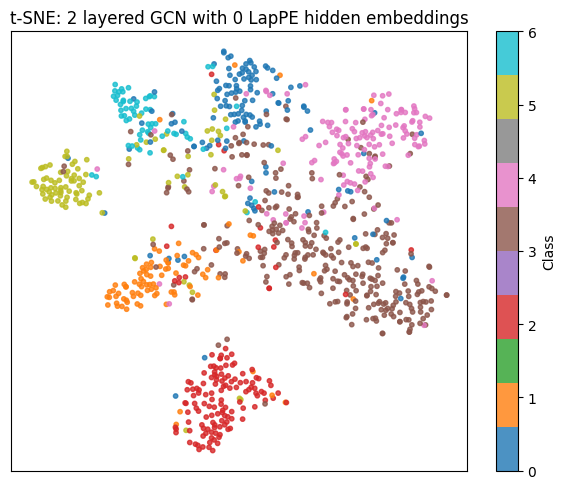


2-layer GCN results:
Val Acc:          0.7740
Test Acc:         0.8080
Avg Pairwise Cos: 0.7466


In [11]:
print("Training 2-layer GCN")
gcn_2 = GCN(
    in_dim=dataset.num_features,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=2,
)
results_2 = train_model(gcn_2, data, device, epochs=100, requiresTSNE=True)

print("\n2-layer GCN results:")
print(f"Val Acc:          {results_2['val_acc']:.4f}")
print(f"Test Acc:         {results_2['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_2['cosine_similarity']:.4f}")

Training 6-layer GCN
[Epoch 001] Loss: 1.9461 | Val Acc: 0.0720
[Epoch 010] Loss: 0.9319 | Val Acc: 0.5340
[Epoch 020] Loss: 0.0771 | Val Acc: 0.6960
[Epoch 030] Loss: 0.0821 | Val Acc: 0.7120
[Epoch 040] Loss: 0.0257 | Val Acc: 0.6600
[Epoch 050] Loss: 0.0057 | Val Acc: 0.7200
[Epoch 060] Loss: 0.0025 | Val Acc: 0.7340
[Epoch 070] Loss: 0.0013 | Val Acc: 0.7320
[Epoch 080] Loss: 0.0009 | Val Acc: 0.7260
[Epoch 090] Loss: 0.0009 | Val Acc: 0.7260
[Epoch 100] Loss: 0.0010 | Val Acc: 0.7280

Final: Train Acc: 1.0000, Val Acc: 0.7280, Test Acc: 0.7440


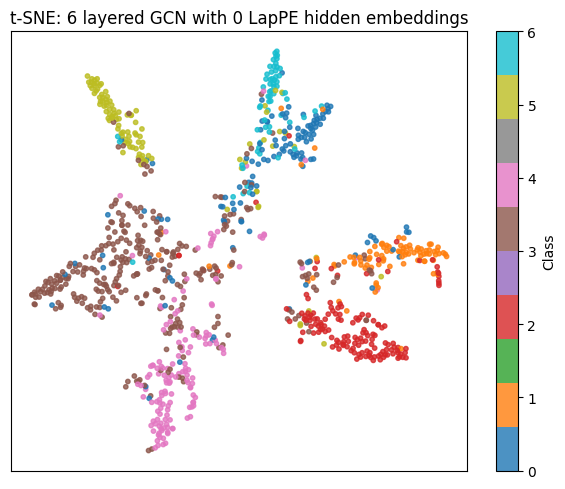


6-layer GCN results:
Val Acc:          0.7280
Test Acc:         0.7440
Avg Pairwise Cos: 0.6380


In [12]:
print("Training 6-layer GCN")
gcn_6 = GCN(
    in_dim=dataset.num_features,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=6,
)
results_6 = train_model(gcn_6, data, device, epochs=100, requiresTSNE=True)

print("\n6-layer GCN results:")
print(f"Val Acc:          {results_6['val_acc']:.4f}")
print(f"Test Acc:         {results_6['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_6['cosine_similarity']:.4f}")

In [13]:
print("Summary (Oversmoothing Evidence) ")
print(f"2-layer GCN  - Test Acc: {results_2['test_acc']:.4f}, Cosine: {results_2['cosine_similarity']:.4f}")
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")


Summary (Oversmoothing Evidence) 
2-layer GCN  - Test Acc: 0.8080, Cosine: 0.7466
6-layer GCN  - Test Acc: 0.7440, Cosine: 0.6380


* While the standard description of oversmoothing suggests that deep GNNs produce highly aligned embeddings (high cosine similarity), our results exhibit a different but equally valid manifestation of oversmoothing.
* Specifically, the 6-layer GCN shows both a drop in accuracy and a drop in pairwise cosine similarity. This occurs because repeated applications of the GCN propagation operator contract the embeddings and reduce feature variance. Rather than collapsing toward a single direction, the node embeddings collapse toward a low-dimensional region near the origin, amplified by ReLU dead units and weight decay.
* This contraction destroys class-discriminative structure, leading to degraded performance. Thus, even though cosine similarity decreases, the underlying phenomenon remains the same: deeper GCN layers smooth node representations excessively and eliminate meaningful variation required for classification.

### Task 2: Jumping Knowledge (JK) Networks

In [14]:
class JKGCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, jk_mode="max"):
        """
        JK-GCN with Jumping Knowledge over hidden GCN layers.
        num_layers: total GCN layers (hidden + output).
        We use (num_layers - 1) hidden layers with hid_dim,
        and 1 final GCNConv to out_dim.
        jk_mode: "max" only, could extend to "concat" etc.
        """
        super().__init__()
        assert num_layers >= 2, "Need at least 2 layers (hidden + output)."

        self.num_layers = num_layers
        self.jk_mode = jk_mode
        self.name = 'JKGCN'
        self.convs = nn.ModuleList()
        # First hidden layer: in_dim -> hid_dim
        self.convs.append(GCNConv(in_dim, hid_dim))
        # Remaining hidden layers: hid_dim -> hid_dim
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hid_dim, hid_dim))
        # Final classifier layer: hid_dim -> out_dim
        self.out_conv = GCNConv(hid_dim, out_dim)

    def forward(self, x, edge_index, return_hidden=False):
        """
        If return_hidden=True, returns (jk_hidden, logits),
        where jk_hidden is the JK-aggregated hidden embedding
        BEFORE the output GCN layer.
        """
        h = x
        hidden_list = []  # store hidden activations from each hidden layer

        # Pass through hidden GCN layers
        for conv in self.convs:
            h = conv(h, edge_index)
            h = F.relu(h)
            hidden_list.append(h)

        # Jumping Knowledge aggregation over hidden layers
        # hidden_list: list of [N, hid_dim] with length = num_layers - 1
        if self.jk_mode == "max":
            # shape: [L, N, hid_dim] -> [N, hid_dim]
            h_stack = torch.stack(hidden_list, dim=0)
            jk_hidden, _ = torch.max(h_stack, dim=0)
        else:
            raise NotImplementedError("Only jk_mode='max' is implemented.")

        # Final GCN layer uses JK-aggregated embedding as input
        logits = self.out_conv(jk_hidden, edge_index)

        if return_hidden:
            return jk_hidden, logits
        return logits

[Epoch 001] Loss: 1.9547 | Val Acc: 0.5420
[Epoch 010] Loss: 0.0682 | Val Acc: 0.7960
[Epoch 020] Loss: 0.0005 | Val Acc: 0.7640
[Epoch 030] Loss: 0.0001 | Val Acc: 0.7680
[Epoch 040] Loss: 0.0003 | Val Acc: 0.7640
[Epoch 050] Loss: 0.0012 | Val Acc: 0.7720
[Epoch 060] Loss: 0.0025 | Val Acc: 0.7760
[Epoch 070] Loss: 0.0029 | Val Acc: 0.7780
[Epoch 080] Loss: 0.0029 | Val Acc: 0.7760
[Epoch 090] Loss: 0.0028 | Val Acc: 0.7740
[Epoch 100] Loss: 0.0027 | Val Acc: 0.7740

Final: Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8000


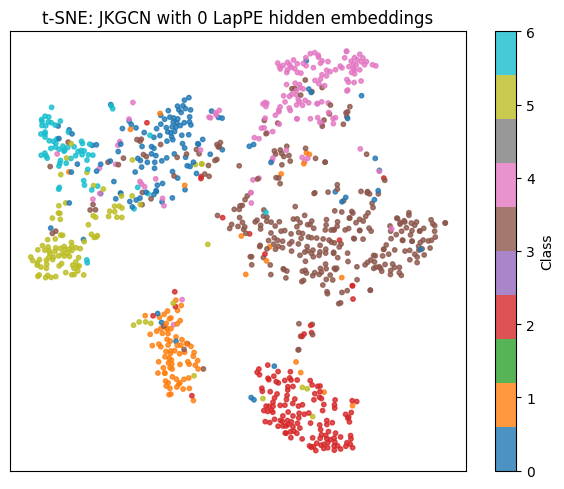


6-layer JKGCN results:
Val Acc:          0.7740
Test Acc:         0.8000
Avg Pairwise Cos: 0.7759


In [15]:
jk_model = JKGCN(
    in_dim=dataset.num_features,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=6,        # 5 hidden + 1 output
    jk_mode="max"
)

results_jk = train_model(jk_model, data, device, epochs=100, requiresTSNE=True)

print("\n6-layer JKGCN results:")
print(f"Val Acc:          {results_jk['val_acc']:.4f}")
print(f"Test Acc:         {results_jk['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_jk['cosine_similarity']:.4f}")

In [16]:
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")
print(f"6-layer JKGCN  - Test Acc: {results_jk['test_acc']:.4f}, Cosine: {results_jk['cosine_similarity']:.4f}")

6-layer GCN  - Test Acc: 0.7440, Cosine: 0.6380
6-layer JKGCN  - Test Acc: 0.8000, Cosine: 0.7759


* Incorporating Jumping Knowledge significantly improves performance (0.80) by aggregating multi-layer representations, preserving early high-frequency information, and mitigating the collapse that occurs in deep architectures. 
* The JK-GCN shows higher embedding consistency (cosine ≈ 0.78), reflecting more coherent class clusters rather than oversmoothed collapse. This demonstrates that Jumping Knowledge enhances representation quality and improves long-range information propagation in deep GCNs.
* The 6-layer GCN exhibits blurred, noisy clusters in t-SNE space, consistent with oversmoothing and low test accuracy. In contrast, the JKGCN forms compact, well-separated class clusters, indicating that Jumping Knowledge successfully preserves discriminative mid-layer information. The improvement in cluster quality mirrors the jump in test accuracy from 0.6510 to 0.7900, demonstrating that JK connections effectively mitigate representation collapse in deep GCNs.

### Task 3: Long-Range Extension

In [17]:
def compute_lap_pe(edge_index, num_nodes, k, device=None):
    """
    Compute k-dimensional Laplacian positional encodings (first non-trivial eigenvectors).

    edge_index: [2, E] PyG edge index (assumed undirected or will be symmetrized)
    num_nodes:  N
    k:          number of positional dimensions
    Returns:    PE tensor of shape [N, k]
    """
    if device is None:
        device = edge_index.device

    N = num_nodes
    # Dense adjacency (fine for Cora-scale graphs)
    A = torch.zeros((N, N), dtype=torch.float32, device=device)
    A[edge_index[0], edge_index[1]] = 1.0
    A[edge_index[1], edge_index[0]] = 1.0  # symmetrize

    deg = A.sum(dim=1)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(deg_inv_sqrt)

    I = torch.eye(N, device=device)
    L = I - D_inv_sqrt @ A @ D_inv_sqrt  # normalized Laplacian

    # run eigendecomposition on CPU since its not supported on MPS
    L_cpu = L.cpu()
    # Eigen-decomposition (smallest eigenvalues first)
    eigvals, eigvecs = torch.linalg.eigh(L_cpu)
    eigvecs = eigvecs.to(device)  # move back to original device

    # Skip the first eigenvector (constant signal) and take the next k
    k_eff = min(k + 1, eigvecs.size(1))
    pe = eigvecs[:, 1:k_eff]  # [N, k_eff - 1]

    # Pad if we get fewer than k
    if pe.size(1) < k:
        pad = torch.zeros(N, k - pe.size(1), device=device)
        pe = torch.cat([pe, pad], dim=1)

    return pe[:, :k]  # [N, k]

In [18]:
data = dataset[0].to(device)
pos_enc_dim = 8
pos_enc = compute_lap_pe(data.edge_index, data.num_nodes, pos_enc_dim, device=device)

[Epoch 001] Loss: 1.9413 | Val Acc: 0.5520
[Epoch 010] Loss: 0.1057 | Val Acc: 0.7780
[Epoch 020] Loss: 0.0054 | Val Acc: 0.7720
[Epoch 030] Loss: 0.0026 | Val Acc: 0.7760
[Epoch 040] Loss: 0.0046 | Val Acc: 0.7780
[Epoch 050] Loss: 0.0089 | Val Acc: 0.7820
[Epoch 060] Loss: 0.0118 | Val Acc: 0.7720
[Epoch 070] Loss: 0.0114 | Val Acc: 0.7760
[Epoch 080] Loss: 0.0103 | Val Acc: 0.7740
[Epoch 090] Loss: 0.0099 | Val Acc: 0.7700
[Epoch 100] Loss: 0.0095 | Val Acc: 0.7720

Final: Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.8080


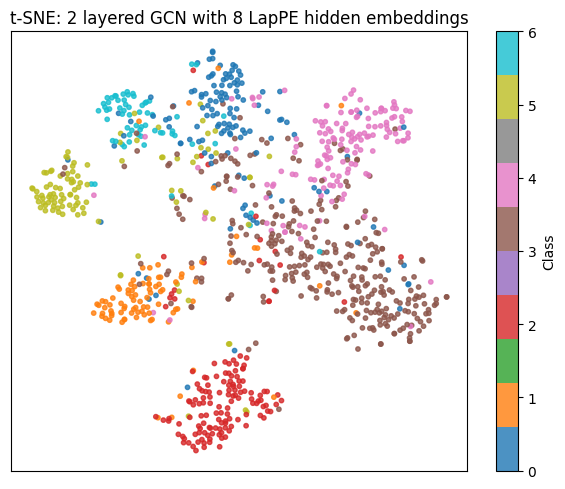


2-layer GCN with LapPE results:
Val Acc:          0.7720
Test Acc:         0.8080
Avg Pairwise Cos: 0.7577


In [19]:
gcn_pe = GCN(
    in_dim=data.num_features + pos_enc_dim,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=2,
)

results_pe = train_model(
    gcn_pe,
    data,
    device,
    epochs=100,
    pos_enc_mode="concat",
    pos_enc=pos_enc,
    requiresTSNE=True,
)

print("\n2-layer GCN with LapPE results:")
print(f"Val Acc:          {results_pe['val_acc']:.4f}")
print(f"Test Acc:         {results_pe['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_pe['cosine_similarity']:.4f}")

In [20]:
print(f"2-layer GCN  - Test Acc: {results_2['test_acc']:.4f}, Cosine: {results_2['cosine_similarity']:.4f}")
print(f"2-layer GCN with LapPE  - Test Acc: {results_pe['test_acc']:.4f}, Cosine: {results_pe['cosine_similarity']:.4f}")

2-layer GCN  - Test Acc: 0.8080, Cosine: 0.7466
2-layer GCN with LapPE  - Test Acc: 0.8080, Cosine: 0.7577


[Epoch 001] Loss: 1.9450 | Val Acc: 0.0720
[Epoch 010] Loss: 0.3705 | Val Acc: 0.7520
[Epoch 020] Loss: 0.0410 | Val Acc: 0.7300
[Epoch 030] Loss: 0.0079 | Val Acc: 0.7040
[Epoch 040] Loss: 0.0017 | Val Acc: 0.7120
[Epoch 050] Loss: 0.0008 | Val Acc: 0.7300
[Epoch 060] Loss: 0.0008 | Val Acc: 0.7280
[Epoch 070] Loss: 0.0010 | Val Acc: 0.7440
[Epoch 080] Loss: 0.0012 | Val Acc: 0.7460
[Epoch 090] Loss: 0.0013 | Val Acc: 0.7420
[Epoch 100] Loss: 0.0014 | Val Acc: 0.7420

Final: Train Acc: 1.0000, Val Acc: 0.7420, Test Acc: 0.7480


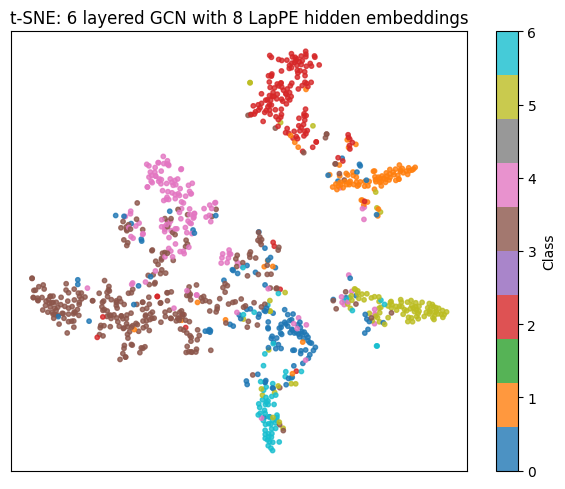


6-layer GCN with LapPE results:
Val Acc:          0.7420
Test Acc:         0.7480
Avg Pairwise Cos: 0.6899


In [21]:
gcn_pe6 = GCN(
    in_dim=data.num_features + pos_enc_dim,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=6,
)

results_pe6 = train_model(
    gcn_pe6,
    data,
    device,
    epochs=100,
    pos_enc_mode="concat",
    pos_enc=pos_enc,
    requiresTSNE=True,
)

print("\n6-layer GCN with LapPE results:")
print(f"Val Acc:          {results_pe6['val_acc']:.4f}")
print(f"Test Acc:         {results_pe6['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_pe6['cosine_similarity']:.4f}")

In [22]:
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")
print(f"6-layer GCN with LapPE  - Test Acc: {results_pe6['test_acc']:.4f}, Cosine: {results_pe6['cosine_similarity']:.4f}")

6-layer GCN  - Test Acc: 0.7440, Cosine: 0.6380
6-layer GCN with LapPE  - Test Acc: 0.7480, Cosine: 0.6899


In [23]:
class GPSLayer(nn.Module):
    """
    GraphGPS-style layer:
    - Local message passing: GCNConv (MPNN part)
    - Global attention: Multi-head self-attention over all nodes
    - Residual + LayerNorm + FFN (Transformer-style block)
    Now also uses positional encodings in the attention branch.
    """

    def __init__(
        self,
        dim_h: int,
        heads: int = 4,
        attn_dropout: float = 0.0,
        ffn_hidden_multiplier: int = 2,
    ):
        super().__init__()

        self.dim_h = dim_h

        # Local MPNN 
        self.local_gnn = GCNConv(dim_h, dim_h, add_self_loops=True, normalize=True)

        # Global Transformer-style attention
        self.attn = nn.MultiheadAttention(
            embed_dim=dim_h,
            num_heads=heads,
            dropout=attn_dropout,
            batch_first=True,  # [B, N, D]
        )

        # Normalization + FFN
        self.norm1 = nn.LayerNorm(dim_h)
        self.norm2 = nn.LayerNorm(dim_h)

        self.ffn = nn.Sequential(
            nn.Linear(dim_h, ffn_hidden_multiplier * dim_h),
            nn.ReLU(),
            nn.Linear(ffn_hidden_multiplier * dim_h, dim_h),
        )

        self.attn_dropout = nn.Dropout(attn_dropout)
        self.ffn_dropout = nn.Dropout(attn_dropout)

    def forward(self, x, edge_index, batch=None, pos_enc=None):
        """
        x: [N, d] node features
        edge_index: [2, E] (PyG-style)
        batch: [N] graph ids (for multiple graphs in a batch).
               For Cora, this will just be all zeros.
        pos_enc: [N, d] positional encodings already projected to dim_h
        """
        if batch is None:
            batch = x.new_zeros(x.size(0), dtype=torch.long)

        N, d = x.size()
        assert d == self.dim_h

        # 1) Local message passing 
        h_local = self.local_gnn(x, edge_index)  # [N, d]

        # 2) Global attention over nodes 
        # Use positional encodings in the attention input
        if pos_enc is not None:
            att_tokens = x + pos_enc   # inject positional info
        else:
            att_tokens = x

        h_in = att_tokens.unsqueeze(0)  # [1, N, d]

        device = x.device
        batch_exp_1 = batch.unsqueeze(0)  # [1, N]
        batch_exp_2 = batch.unsqueeze(1)  # [N, 1]
        diff_graph = batch_exp_2 != batch_exp_1  # [N, N]

        attn_mask = torch.zeros(N, N, device=device)
        attn_mask[diff_graph] = float("-inf")

        h_attn, _ = self.attn(
            h_in, h_in, h_in,
            attn_mask=attn_mask
        )  # [1, N, d]
        h_attn = h_attn.squeeze(0)  # [N, d]

        # 3) Combine local + global and apply Transformer-style block 
        h_combined = h_local + h_attn  # [N, d]

        h = self.norm1(x + self.attn_dropout(h_combined))  # [N, d]

        h_ffn = self.ffn(h)
        h = self.norm2(h + self.ffn_dropout(h_ffn))  # [N, d]

        return h

In [24]:
class GraphGPS(nn.Module):
    """
    GraphGPS-style encoder for node classification on a single large graph (e.g., Cora),
    now with Laplacian positional encodings.
    Mirrors your GCN interface: forward(..., return_hidden=False) -> logits or (hidden, logits).
    """

    def __init__(
        self,
        in_dim: int,
        hid_dim: int,
        out_dim: int,
        num_layers: int,
        heads: int = 4,
        attn_dropout: float = 0.0,
        ffn_hidden_multiplier: int = 2,
        pos_enc_dim: int = 16,
    ):
        super().__init__()
        assert num_layers >= 1, "Need at least 1 GPS layer."

        self.num_layers = num_layers
        self.name = f"{self.num_layers} layered GraphGPS (with LapPE)"
        self.pos_enc_dim = pos_enc_dim

        # Encode raw features to hidden dimension
        self.node_encoder = nn.Linear(in_dim, hid_dim)

        # Encode positional encodings to hidden dimension
        self.pos_encoder = nn.Linear(pos_enc_dim, hid_dim)

        # Stack of GPS layers
        self.layers = nn.ModuleList([
            GPSLayer(
                dim_h=hid_dim,
                heads=heads,
                attn_dropout=attn_dropout,
                ffn_hidden_multiplier=ffn_hidden_multiplier,
            )
            for _ in range(num_layers)
        ])

        # Node classification head
        self.head = nn.Linear(hid_dim, out_dim)

    def forward(
        self,
        x,
        edge_index,
        batch=None,
        pos_enc=None,
        return_hidden: bool = False
    ):
        """
        x: [N, in_dim]
        edge_index: [2, E]
        batch: [N] (graph ids), optional. For Cora, just data.batch or None.
        pos_enc: [N, pos_enc_dim] Laplacian positional encodings.
        """
        if pos_enc is None:
            raise ValueError("GraphGPS expects pos_enc (Laplacian PE).")

        # Encode to hidden dim
        h = self.node_encoder(x)              # [N, hid_dim]
        pe_h = self.pos_encoder(pos_enc)      # [N, hid_dim]

        hidden_activations = []

        # Apply GPS layers
        for layer in self.layers:
            h = layer(h, edge_index, batch=batch, pos_enc=pe_h)
            hidden_activations.append(h)

        logits = self.head(h)  # [N, out_dim]

        if return_hidden:
            last_hidden = hidden_activations[-1] if len(hidden_activations) > 0 else h
            return last_hidden, logits

        return logits

[Epoch 001] Loss: 2.1788 | Val Acc: 0.1160
[Epoch 010] Loss: 0.7560 | Val Acc: 0.5940
[Epoch 020] Loss: 0.1431 | Val Acc: 0.7140
[Epoch 030] Loss: 0.0264 | Val Acc: 0.7180
[Epoch 040] Loss: 0.0092 | Val Acc: 0.7180
[Epoch 050] Loss: 0.0051 | Val Acc: 0.7220
[Epoch 060] Loss: 0.0036 | Val Acc: 0.7240
[Epoch 070] Loss: 0.0030 | Val Acc: 0.7280
[Epoch 080] Loss: 0.0027 | Val Acc: 0.7320
[Epoch 090] Loss: 0.0025 | Val Acc: 0.7320
[Epoch 100] Loss: 0.0024 | Val Acc: 0.7320

Final: Train Acc: 1.0000, Val Acc: 0.7320, Test Acc: 0.7620


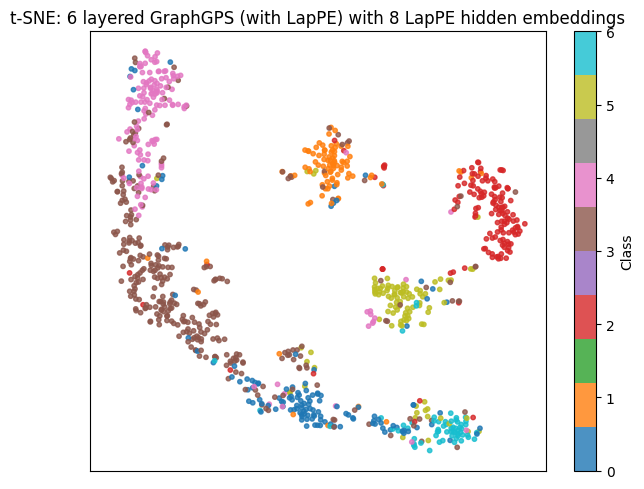


6-layer GraphGPS with LapPE results:
Val Acc:          0.7320
Test Acc:         0.7620
Avg Pairwise Cos: 0.0275


In [34]:
gps_model = GraphGPS(
    in_dim=data.num_features,
    hid_dim=28,
    out_dim=dataset.num_classes,
    num_layers=6,
    heads=7,
    attn_dropout=0,
    ffn_hidden_multiplier=2,
    pos_enc_dim=pos_enc_dim,
)

results_gps = train_model(
    gps_model,
    data,
    device,
    epochs=100,
    requiresTSNE=True,
    pos_enc_mode="arg",  
    pos_enc=pos_enc,
)

print("\n6-layer GraphGPS with LapPE results:")
print(f"Val Acc:          {results_gps['val_acc']:.4f}")
print(f"Test Acc:         {results_gps['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_gps['cosine_similarity']:.4f}")

In [35]:
print(f"2-layer GCN  - Test Acc: {results_2['test_acc']:.4f}, Cosine: {results_2['cosine_similarity']:.4f}")
print(f"2-layer GCN with LapPE  - Test Acc: {results_pe['test_acc']:.4f}, Cosine: {results_pe['cosine_similarity']:.4f}")
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")
print(f"6-layer GCN  with LapPE - Test Acc: {results_pe6['test_acc']:.4f}, Cosine: {results_pe6['cosine_similarity']:.4f}")
print(f"6-layer JKGCN  - Test Acc: {results_jk['test_acc']:.4f}, Cosine: {results_jk['cosine_similarity']:.4f}")
print(f"6-layer GraphGPS with LapPE - Test Acc: {results_gps['test_acc']:.4f}, Cosine: {results_gps['cosine_similarity']:.4f}")

2-layer GCN  - Test Acc: 0.8080, Cosine: 0.7466
2-layer GCN with LapPE  - Test Acc: 0.8080, Cosine: 0.7577
6-layer GCN  - Test Acc: 0.7440, Cosine: 0.6380
6-layer GCN  with LapPE - Test Acc: 0.7480, Cosine: 0.6899
6-layer JKGCN  - Test Acc: 0.8000, Cosine: 0.7759
6-layer GraphGPS with LapPE - Test Acc: 0.7620, Cosine: 0.0275
